In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as mplot
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.colors import ListedColormap
import os
import subprocess
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score,  precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
 
from sklearn.tree import export_graphviz
import pydotplus
import seaborn as sns

import random
 


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.datasets import mnist 
 
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import AUC, Precision, Recall, F1Score
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K



import pickle 

import shap
import lime
from lime import lime_tabular
import random

import dalex as dx 


from tabulate import tabulate 


# Define custom metrics
recall = Recall()
precision = Precision()
f1_score = F1Score()
auc = AUC()






IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
dataSetIndex = 4
needToMakePictureOfTrees = 0
''' ---------------------------------------------------------- '''
dataSetFilePath = ""
dataSetName = ""
dataSetResultDirectory = "./"

if(dataSetIndex == 0):
    dataSetFilePath = "./heartDisease/0_statLog_dataSet.csv"
    dataSetName = "SateLog_DataSet"
elif (dataSetIndex == 1):
    dataSetFilePath = "./heartDisease/1_heart_statlog_cleveland_hungary_final.csv"
    dataSetName = "ALL_StateLog_CleveLand_Hungary"
elif (dataSetIndex == 2):
    dataSetFilePath = "./heartDisease/2_cleveland.csv"
    dataSetName = "Cleveland"
elif (dataSetIndex == 3):
    dataSetFilePath = "./heartDisease/3_framingham.csv"
    dataSetName = "framingham"
elif (dataSetIndex == 4):
    dataSetFilePath = "./heartDisease/4_CardiacPrediction.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 5):
    dataSetFilePath = "./heartDisease/5_CardiacPredictionLessDimensions.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 6):
    dataSetFilePath = "./heartDisease/6_CardiacPredictionFewDimensions.xlsx"
    dataSetName = "CardiacPrediction"
else:
    dataSetFilePath = ""
    dataSetName = ""

if(dataSetIndex==4 or dataSetIndex==5 or dataSetIndex==6):
    #fileData = pd.read_excel(dataSetFilePath, sheet_name='CoroHeartDis')
    fileData = pd.read_excel(dataSetFilePath)
else:
    fileData = pd.read_csv(dataSetFilePath)

print("Shape of fileData: {}".format(fileData.shape))
print("Column Headings: {}".format(fileData.__dataframe__().column_names()))
print("Number of Records: {}".format(fileData.__dataframe__().num_rows()))


missingValues = fileData.isnull().any().sum()
print(f"\nNumber of Missing Values: {missingValues}")

num_rows_before = fileData.shape[0]
# Remove duplicate records based on all columns
fileData.drop_duplicates(inplace=True)
# Check the number of rows after removing duplicates
num_rows_after = fileData.shape[0]
# Print the number of duplicate records removed
num_duplicates_removed = num_rows_before - num_rows_after
print(f"Number of duplicate records removed: {num_duplicates_removed}")
 
 # Preprocess Steps from the ChatGPT
# 1. Handling Missing Values:
fileData = fileData.dropna()
print("Shape of fileData: {}".format(fileData.shape))              
#fileData.replace({'?': np.nan}).dropna().astype(float)
#fileData = fileData.fillna(0) 

fileData = fileData.fillna(0) 

print("Shape of fileData End: {}".format(fileData.shape))



finalResultTable = [ ['Index', 'Method', 'Accuracy %','Recall %','Precision %','F1 Score','AUC'], ]  

X = fileData.drop(fileData.__dataframe__().column_names()[-1], axis=1)  # Features
Y = fileData[fileData.__dataframe__().column_names()[-1]]  # Labels

columns = fileData.__dataframe__().column_names() 
totalRecords = (fileData.__dataframe__().num_rows())

print("\n")
print("columns of x:: {} \n\n and features of X: {}".format(len(X.columns), X.columns))

dataSetResultDirectory = "./"
dataSetResultDirectory += ("DatasetResults_MLP_with_AttentionLayers_Extended_2_" + dataSetName)
dataSetResultDirectory += "/"
if not os.path.isdir(dataSetResultDirectory):
    os.makedirs(dataSetResultDirectory)

dataSetName += "_{}".format(fileData.shape)



Shape of fileData: (37079, 51)
Column Headings: Index(['SEQN', 'Gender', 'Age', 'Annual-Family-Income',
       'Ratio-Family-Income-Poverty', 'X60-sec-pulse', 'Systolic', 'Diastolic',
       'Weight', 'Height', 'Body-Mass-Index', 'White-Blood-Cells',
       'Lymphocyte', 'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells',
       'Hemoglobin', 'Mean-Cell-Vol', 'Mean-Cell-Hgb-Conc.',
       'Mean-cell-Hemoglobin', 'Platelet-count', 'Mean-Platelet-Vol',
       'Segmented-Neutrophils', 'Hematocrit', 'Red-Cell-Distribution-Width',
       'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose',
       'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Vigorous-work', 'Moderate-work', 'Health-Insurance', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke', 'CoronaryHeartDisease'],
      dtype='object')
Number of Records: 37079

Number of Missing Values: 0
Number o

Target Column Name: CoronaryHeartDisease


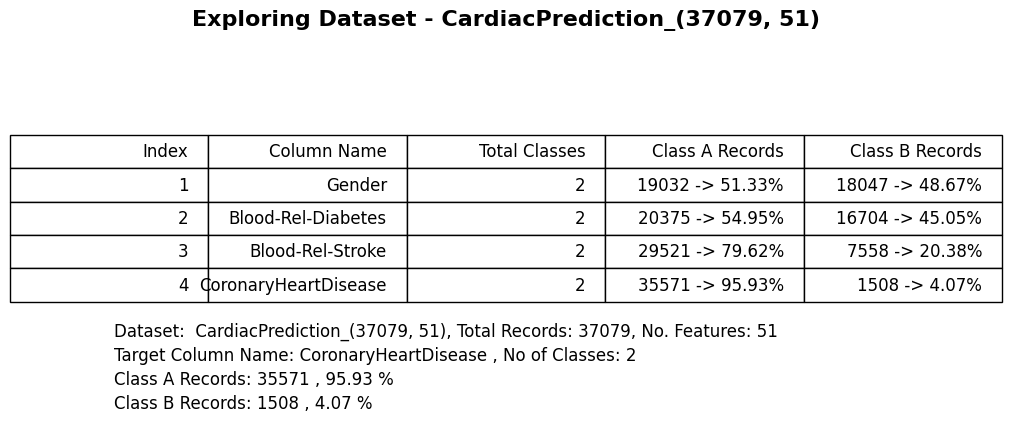

In [3]:
columns = fileData.__dataframe__().column_names() 
totalRecords = (fileData.__dataframe__().num_rows())
columnsForGraph = []
columnsForGraph.clear()
tableDataRow = []
for column in columns:
    singleColumnCount = fileData[column].value_counts()
    if(len(singleColumnCount) < 3):
        #print('Column Name:{} -> total records:{}'.format(column, totalRecords ) )
        #print('Number of classes:', len(singleColumnCount))
        #print('Class distribution:')
        #print(singleColumnCount)
        #print("np Array: {}".format(np.array(singleColumnCount)))
        #print("index: 0: {} -> {} %".format(np.array(singleColumnCount)[0], (np.array(singleColumnCount)[0] /totalRecords) * 100))
        #print("index: 1: {} -> {} %".format(np.array(singleColumnCount)[1], ( np.array(singleColumnCount)[1] /totalRecords) * 100))  
        #print('---------------------------------------------------------------')
        columnsForGraph.append(column)
 

tableDataRow = [
    ['Index', 'Column Name', 'Total Classes','Class A Records','Class B Records'],
    
]

indexx = 1
for column in columnsForGraph:
    singleColumnCount = fileData[column].value_counts()
    singleRowInTable = [] 
    singleRowInTable.append(indexx)
    singleRowInTable.append(column)
    singleRowInTable.append(len(singleColumnCount))
    cellDataString = "{} -> {:.2f}%".format(np.array(singleColumnCount)[0], (np.array(singleColumnCount)[0] /totalRecords) * 100)
    singleRowInTable.append((cellDataString)) 
    cellDataString = "{} -> {:.2f}%".format(np.array(singleColumnCount)[1], (np.array(singleColumnCount)[1] /totalRecords) * 100)
    singleRowInTable.append((cellDataString)) 
    indexx += 1
    tableDataRow.append(singleRowInTable) 

# Create the figure and axes
fig, ax = mplot.subplots() 
table = mplot.table(cellText=tableDataRow, loc='center') 

table.auto_set_font_size(False)
table.set_fontsize(12) 
table.scale(2.0, 2.0) 
print("Target Column Name: {}".format(columns[-1]))


dataSetString = "Dataset:  {}, Total Records: {}, No. Features: {}".format(dataSetName, totalRecords, fileData.__dataframe__().num_columns())
target ="Target Column Name: {} , No of Classes: {}".format(columns[-1], len(fileData[columns[-1]].value_counts()))
distributionOfTargetClassA ="Class A Records: {} , {:.2f} %".format(np.array(fileData[columns[-1]].value_counts())[0], (np.array(fileData[columns[-1]].value_counts())[0] /totalRecords) * 100)
distributionOfTargetClassB ="Class B Records: {} , {:.2f} %".format(np.array(fileData[columns[-1]].value_counts())[1], (np.array(fileData[columns[-1]].value_counts())[1] /totalRecords) * 100)

fig.text(-0.1, +0.25,  dataSetString, horizontalalignment='left', wrap=False , fontsize=12 )  
fig.text(-0.1, +0.20,  target, horizontalalignment='left', wrap=False  , fontsize=12 )   
fig.text(-0.1, 0.15,  distributionOfTargetClassA, horizontalalignment='left', wrap=False , fontsize=12  )   
fig.text(-0.1, 0.10,  distributionOfTargetClassB, horizontalalignment='left', wrap=False  , fontsize=12 )   
 
 
mplot.axis('off')
mplot.title(f'Exploring Dataset - {dataSetName}' ,fontsize=16, fontweight='bold') 

picturePath = "{}1.DataSet_analysis_{}.png".format(dataSetResultDirectory, dataSetName)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
#mplot.savefig('DataSet_analysis.png', dpi=300)
mplot.show()
mplot.close()
 

In [4]:
print("Shape of fileData: {} , target Len:{}".format(fileData.shape, len(Y)))
print("X: {} , Y:{}".format(X.shape, Y.shape))
#print("\n\nX: head:: \n{}".format(X.head()))
#print("\n\nY: head::\n {}".format(Y.head()))

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
 

print("Target Column Name:: {} \n".format(fileData.__dataframe__().column_names()[-1]))


rus = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)

'''
# Undersample the majority class
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
'''

# Oversample the minority class using SMOTE
X_train, y_train = smote.fit_resample(X_train, y_train)
#X_test, y_test = rus.fit_resample(X_test, y_test)
X_test, y_test = smote.fit_resample(X_test, y_test) 


scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



print("\n X Train: Shape:: {}".format(X_train.shape))
print(" X Test: Shape:: {}".format(X_test.shape))  
 
 
positiveClass =  0
negativeClass = 0
for i in y_train:
    if(i == 0):
        negativeClass += 1
    if(i == 1):
        positiveClass += 1
print("Train DataSet Positive Class Records:: {}".format(positiveClass)) 
print("Train DataSet Negative Class Records:: {}".format(negativeClass)) 
print("Train DataSet Total Records:: {}".format(positiveClass + negativeClass)) 

print("\n\n") 


positiveClass =  0
negativeClass = 0
for i in y_test:
    if(i == 0):
        negativeClass += 1
    if(i == 1):
        positiveClass += 1
print("Test DataSet Positive Class Records:: {}".format(positiveClass)) 
print("Test DataSet Negative Class Records:: {}".format(negativeClass)) 
print("Test DataSet Total Records:: {}".format(positiveClass + negativeClass)) 



Shape of fileData: (37079, 51) , target Len:37079
X: (37079, 50) , Y:(37079,)
Target Column Name:: CoronaryHeartDisease 


 X Train: Shape:: (56914, 50)
 X Test: Shape:: (14228, 50)
Train DataSet Positive Class Records:: 28457
Train DataSet Negative Class Records:: 28457
Train DataSet Total Records:: 56914



Test DataSet Positive Class Records:: 7114
Test DataSet Negative Class Records:: 7114
Test DataSet Total Records:: 14228


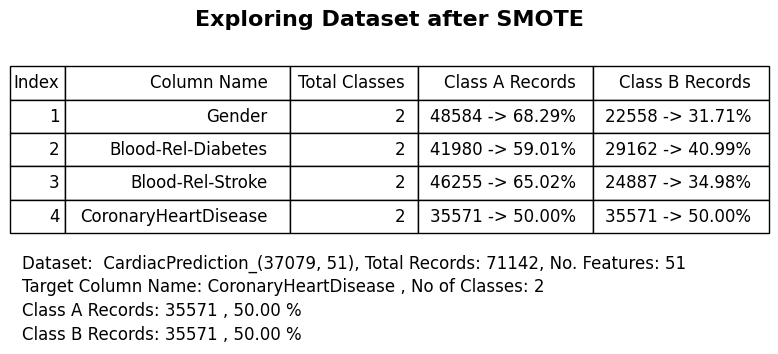

In [5]:

columnsForGraph = []
columnsForGraph.clear()
tableDataRow = []


# Concatenate feature and target data for both training and testing sets
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
df_combined = pd.concat([df_train, df_test], axis=0, ignore_index=True)

columns = df_combined.__dataframe__().column_names() 
totalRecords = (df_combined.__dataframe__().num_rows())
for column in columns:
    singleColumnCount = df_combined[column].value_counts()
    if(len(singleColumnCount) < 3):
        #print('Column Name:{} -> total records:{}'.format(column, totalRecords ) )
        #print('Number of classes:', len(singleColumnCount))
        #print('Class distribution:')
        #print(singleColumnCount)
        #print("np Array: {}".format(np.array(singleColumnCount)))
        #print("index: 0: {} -> {} %".format(np.array(singleColumnCount)[0], (np.array(singleColumnCount)[0] /totalRecords) * 100))
        #print("index: 1: {} -> {} %".format(np.array(singleColumnCount)[1], ( np.array(singleColumnCount)[1] /totalRecords) * 100))  
        #print('---------------------------------------------------------------')
        columnsForGraph.append(column)
 
tableDataRow = [ ['Index', 'Column Name', 'Total Classes','Class A Records','Class B Records'], ]

indexx = 1
for column in columnsForGraph:
    singleColumnCount = df_combined[column].value_counts()
    singleRowInTable = [] 
    singleRowInTable.append(indexx)
    singleRowInTable.append(column)
    singleRowInTable.append(len(singleColumnCount))
    cellDataString = "{} -> {:.2f}%".format(np.array(singleColumnCount)[0], (np.array(singleColumnCount)[0] /totalRecords) * 100)
    singleRowInTable.append((cellDataString)) 
    cellDataString = "{} -> {:.2f}%".format(np.array(singleColumnCount)[1], (np.array(singleColumnCount)[1] /totalRecords) * 100)
    singleRowInTable.append((cellDataString)) 
    indexx += 1
    tableDataRow.append(singleRowInTable) 

 
# Determine the number of rows in the table (excluding the header)
num_rows = len(tableDataRow) + 1
# Calculate the desired figure size based on the number of rows
fig_width = 6  # Set the desired width of the figure
fig_height = num_rows * 0.5  # Adjust the scaling factor to control the height

fig, ax = mplot.subplots(figsize=(fig_width, fig_height)) 
table = mplot.table(cellText=tableDataRow, loc='center') 

table.auto_set_column_width(col=list(range(len(tableDataRow[0]))))

table.auto_set_font_size(False)
table.set_fontsize(12) 
table.scale(2.0, 2.0) 

dataSetString = "Dataset:  {}, Total Records: {}, No. Features: {}".format(dataSetName, totalRecords, df_combined.__dataframe__().num_columns())
target ="Target Column Name: {} , No of Classes: {}".format(columns[-1], len(df_combined[columns[-1]].value_counts()))
distributionOfTargetClassA ="Class A Records: {} , {:.2f} %".format(np.array(df_combined[columns[-1]].value_counts())[0], (np.array(df_combined[columns[-1]].value_counts())[0] /totalRecords) * 100)
distributionOfTargetClassB ="Class B Records: {} , {:.2f} %".format(np.array(df_combined[columns[-1]].value_counts())[1], (np.array(df_combined[columns[-1]].value_counts())[1] /totalRecords) * 100)

fig.text(-0.1, +0.10,  dataSetString, horizontalalignment='left', wrap=False , fontsize=12 )  
fig.text(-0.1, +0.02,  target, horizontalalignment='left', wrap=False  , fontsize=12 )   
fig.text(-0.1, -0.06,  distributionOfTargetClassA, horizontalalignment='left', wrap=False , fontsize=12  )   
fig.text(-0.1, -0.14,  distributionOfTargetClassB, horizontalalignment='left', wrap=False  , fontsize=12 )   

remarks = "You need to distribute the target class in equal number of records in training-set."
#fig.text(-0.2, -0.15,  remarks, horizontalalignment='left', wrap=True ,fontsize=12, fontweight='bold' )   
 
mplot.axis('off')
mplot.title(f'Exploring Dataset after SMOTE' ,fontsize=16, fontweight='bold') 
picturePath = "{}02.DataSet_analysis_After_dataAugmentation_{}.png".format(dataSetResultDirectory, dataSetName)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
#mplot.savefig(picturePath,  dpi=300 )
mplot.show()
mplot.close()

In [6]:
def makeCorrelationPic(correlationMatrix, numberOfTopFeatures, targetColumnName):     
    correlation_values = correlationMatrix.abs()
    sorted_correlation = correlation_values.unstack().sort_values(ascending=False)
    sorted_correlation = sorted_correlation[sorted_correlation != 1.0]

    num_features = numberOfTopFeatures  # Number of top features to display
    top_features = sorted_correlation.head(num_features)
    print("Top", num_features, "features based on correlation:")
    print(top_features)
 
    top_features = correlationMatrix.abs().nlargest(numberOfTopFeatures, targetColumnName)[targetColumnName].index
    top_correlation_matrix = correlationMatrix.loc[top_features, top_features]

    mplot.figure(figsize=(10, 8))
    sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm')
    # Set the title of the plot
    mplot.title('Correlation Heatmap ({})'.format(dataSetName))
    
    picturePath = "Correlation_Matrix_DateSetName_{}.png".format(dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    mplot.show()
    mplot.close()

def makeConfusionMatrixPic(method, dataSet, classifierObj , X_test, y_test, predicted_Y):
    display = ConfusionMatrixDisplay.from_estimator(classifierObj, X_test, y_test, display_labels=['Healthy', "Heart Disease"], cmap=mplot.cm.Blues) #, normalize="true"
    display.ax_.set_title("Confusion Matrix ({} Model)".format(method))
    ax_.set_xlabel('\nPredicted Values')
    ax_.set_ylabel('Actual Values ')


    accuracyString ="Accuracy {}: {:.2f}".format(method, accuracy_score(y_test, predicted_Y)*100.0 ) 
    recallString =  'Recall {}: {:.2f}'.format(method, recall_score(y_test, predicted_Y) * 100.0)
    precisionString = 'Precision {}: {:.2f}'.format(method, precision_score(y_test, predicted_Y) * 100.0) 
    dataSetString = "Dataset: {}".format(dataSet)

    
    if(classifierObj.n_features_in_ > 10):
        featureListString = 'Total Features: {}'.format(classifierObj.n_features_in_) 
    else:
        featureListString = 'Features: {}'.format(classifierObj.feature_names_in_) 
    
    display.figure_.text(0.010, -0.05,  accuracyString, horizontalalignment='left', wrap=False )  
    display.figure_.text(0.010, -0.09,  recallString, horizontalalignment='left', wrap=False )      
    display.figure_.text(0.010, -0.13,  precisionString, horizontalalignment='left', wrap=False ) 
    display.figure_.text(0.010, -0.17,  dataSetString, horizontalalignment='left', wrap=False ) 
    display.figure_.text(0.010, -0.28,  featureListString, horizontalalignment='left', wrap=False ) 
 
    picturePath = "{}Confusion_Matrix_{}_{}.png".format(dataSetResultDirectory, method, dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    #print("{} Confusion Matrix saved:: path: {}".format(method, picturePath))
    #os.startfile(picturePath)
    mplot.show()
    mplot.close()


In [7]:
X_train_normalized = tf.keras.utils.normalize(X_train, axis=1)
X_test_normalized = tf.keras.utils.normalize(X_test, axis=1)

scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.fit_transform(X_test) 
# Our vectorized labels

X_train_f32 = np.asarray(X_train).astype(np.float32)  #.astype('float32').reshape((-1,1))
X_test_f32 = np.asarray(X_test).astype(np.float32)

#y_train_scaler = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test_scaler = np.asarray(y_test).astype('float32').reshape((-1,1))

 

# Separate features and target variable
features = X_train_scaler # data.iloc[:, :-1]
target = np.asarray(y_train).astype('float64').reshape((-1,1))  #data['CoronaryHeartDisease']
 
 

print("X_train shape: {}   and dType: {}".format(X_train.shape, len(X_train.columns)))
print("X_train_scaler shape: {}   and dType: {}".format(X_train_scaler.shape, X_train_scaler.dtype))
print("X_test_scaler shape: {}   and dType: {}".format(X_test_scaler.shape, X_test_scaler.dtype)) 


print("y_train shape: {}   and dType: {}".format(y_train.shape, y_train.dtype))  
print("y_test_scaler shape: {}   and dType: {}".format(y_test_scaler.shape, y_test_scaler.dtype))  


print("features shape: {}   and dType: {}".format(features.shape, features.dtype))
print("target shape: {}   and dType: {}".format(target.shape, target.dtype)) 

X_train shape: (56914, 50)   and dType: 50
X_train_scaler shape: (56914, 50)   and dType: float64
X_test_scaler shape: (14228, 50)   and dType: float64
y_train shape: (56914,)   and dType: int64
y_test_scaler shape: (14228, 1)   and dType: float32
features shape: (56914, 50)   and dType: float64
target shape: (56914, 1)   and dType: float64


In [8]:
tf.keras.backend.clear_session()
# Define the attention layer
print("Number of Node: {}".format(features.shape[1]//2))
print("Number 2 of Node: {}".format(features.shape[1]//1.5))

def recall_model(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_model(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

class AttentionLayer(tf.keras.layers.Layer):
    def call(self, inputs, **kwargs):
        q, v = inputs
        attention = tf.keras.layers.Attention()([q, v])
        return attention

# Build the model
input_layer = Input(shape=(features.shape[1],))

# Traditional neural network part
x = layers.Dense(features.shape[1]*2, activation='relu')(input_layer)
x = layers.Dense(features.shape[1], activation='relu')(x) 
x = layers.Dense(features.shape[1], activation='relu')(x) 
x = layers.BatchNormalization()(x)
 
attention = AttentionLayer()([x, x]) 
x = layers.Concatenate()([x, attention])
x = layers.Dense(features.shape[1], activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(features.shape[1]//2, activation='relu')(x)
# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(x)



model = tf.keras.Model(inputs=input_layer, outputs=output_layer) 
optimizer = AdamW(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', recall, precision, f1_score, auc])

  


Number of Node: 25
Number 2 of Node: 33.0


In [9]:
#model.summary() 

In [10]:
numberOfEpochs = 40
batchSizeOfTraining = 25
model_history = 0

model_history = model.fit(features, target, epochs=numberOfEpochs, batch_size=batchSizeOfTraining)

model2 = model




Epoch 1/40


2277/2277 [==============================] - 4s 1ms/step - loss: 0.2717 - accuracy: 0.8879 - recall: 0.9061 - precision: 0.8744 - f1_score: 0.6667 - auc: 0.9537
Epoch 2/40
2277/2277 [==============================] - 3s 1ms/step - loss: 0.2103 - accuracy: 0.9170 - recall: 0.9342 - precision: 0.9031 - f1_score: 0.6667 - auc: 0.9716
Epoch 3/40
2277/2277 [==============================] - 3s 1ms/step - loss: 0.1777 - accuracy: 0.9325 - recall: 0.9471 - precision: 0.9202 - f1_score: 0.6667 - auc: 0.9789
Epoch 4/40
2277/2277 [==============================] - 2s 1ms/step - loss: 0.1529 - accuracy: 0.9444 - recall: 0.9578 - precision: 0.9328 - f1_score: 0.6667 - auc: 0.9837
Epoch 5/40
2277/2277 [==============================] - 2s 1ms/step - loss: 0.1347 - accuracy: 0.9516 - recall: 0.9628 - precision: 0.9417 - f1_score: 0.6667 - auc: 0.9869
Epoch 6/40
2277/2277 [==============================] - 3s 1ms/step - loss: 0.1221 - accuracy: 0.9563 - recall: 0.9657 - precision: 0.9479

In [11]:

y_test_float64 = np.asarray(y_test).astype('float64').reshape((-1,1))  #data['CoronaryHeartDisease']
history = model2.fit(X_test_scaler, y_test_float64, epochs=2, batch_size=batchSizeOfTraining)

Epoch 1/2
570/570 [==============================] - 1s 1ms/step - loss: 0.2588 - accuracy: 0.9027 - recall: 0.9141 - precision: 0.8936 - f1_score: 0.6667 - auc: 0.9587
Epoch 2/2
570/570 [==============================] - 1s 1ms/step - loss: 0.1446 - accuracy: 0.9486 - recall: 0.9591 - precision: 0.9393 - f1_score: 0.6667 - auc: 0.9851


In [12]:
# Evaluate the model using the evaluate method
y_test_float64 = np.asarray(y_test).astype('float64').reshape((-1,1))  #data['CoronaryHeartDisease']

loss, accuracy, recall_value, precision_value, f1_score_value, auc_value = model2.evaluate(X_test_scaler, y_test_float64)

# Print the results
print('Test loss: {}'.format(loss*100))
print('Test accuracy: {}'.format(accuracy*100))
print('Test recall: {}'.format(recall_value*100))
print('Test precision: {}'.format(precision_value*100))
print('Test F1 score: {}'.format(f1_score_value*100))
print('Test AUC: {}'.format(auc_value*100))


picturePath = "{}Model_Evaluation_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, "Testing_Accuracy", dataSetName, numberOfEpochs)


445/445 [==============================] - 1s 811us/step - loss: 0.0943 - accuracy: 0.9691 - recall: 0.9741 - precision: 0.9645 - f1_score: 0.6669 - auc: 0.9932
Test loss: 9.429576247930527
Test accuracy: 96.91453576087952
Test recall: 97.41355180740356
Test precision: 96.450936794281
Test F1 score: [66.688545]
Test AUC: 99.32218790054321


445/445 [==============================] - 0s 657us/step
MLP with Attention layer Confusion Matrix saved:: path: ./DatasetResults_MLP_with_AttentionLayers_Extended_2_CardiacPrediction/Model_Evaluation_MLP with Attention layer_CardiacPrediction_(37079, 51)_Epoch_40.png


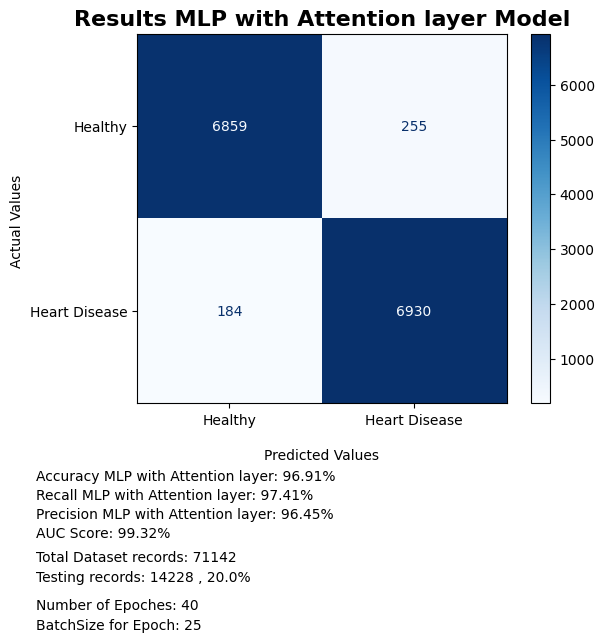

In [13]:
threshold = 0.5  # Adjust the threshold as needed
binary_predictions = (model2.predict(X_test_scaler) > threshold).astype(int)

cm = confusion_matrix(y_test_float64, binary_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Heart Disease'])

display.plot(cmap=plt.cm.Blues, values_format=".4g") 


method = "MLP with Attention layer"
display.ax_.set_title("Results {} Model".format(method),fontsize=16, fontweight='bold')
display.ax_.set_xlabel('\nPredicted Values')
display.ax_.set_ylabel('Actual Values ')

accuracyString ="Accuracy {}: {:.2f}%".format(method, accuracy*100.0 ) 
recallString =  'Recall {}: {:.2f}%'.format(method, recall_value* 100.0)
precisionString = 'Precision {}: {:.2f}%'.format(method, precision_value * 100.0) 
#f1String = "F1 Score: {:.2f}".format(f1_score_value * 100.0)
featureListString = "AUC Score: {:.2f}%".format(auc_value * 100.0)
totaldataSetString = "Total Dataset records: {}".format((len(features)+len(X_test_scaler)))
testingdataSetString = "Testing records: {} , {:.1f}%".format(len(X_test_scaler), ( ( len(X_test_scaler) / (len(features)+len(X_test_scaler)) )*100.0  ))
numberOfEpochsString = "Number of Epoches: {}".format(numberOfEpochs)
batchSizeOfTrainingString = "BatchSize for Epoch: {}".format(batchSizeOfTraining)

display.figure_.text(0.010, -0.05,  accuracyString, horizontalalignment='left', wrap=False )  
display.figure_.text(0.010, -0.09,  recallString, horizontalalignment='left', wrap=False )      
display.figure_.text(0.010, -0.13,  precisionString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.17,  featureListString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.22,  totaldataSetString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.26,  testingdataSetString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.32,  numberOfEpochsString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.36,  batchSizeOfTrainingString, horizontalalignment='left', wrap=False ) 
 
picturePath = "{}Model_Evaluation_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, method, dataSetName, numberOfEpochs)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
print("{} Confusion Matrix saved:: path: {}".format(method, picturePath))

mplot.show()
mplot.close()


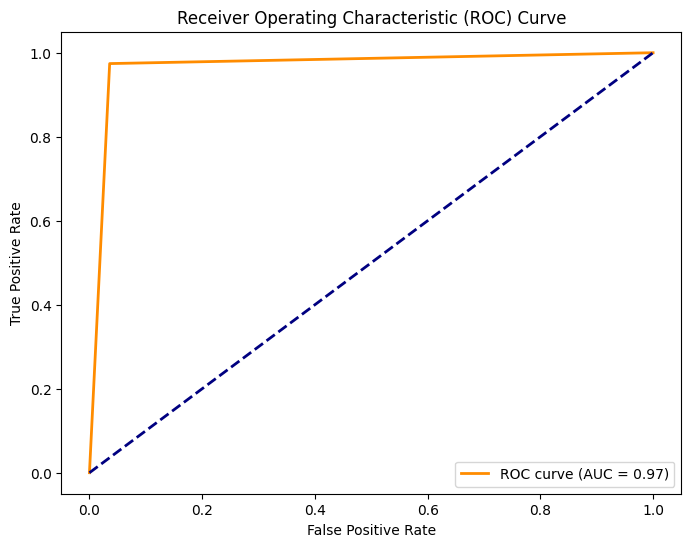

In [14]:
# Calculate AUC
auc_score = roc_auc_score(y_test, binary_predictions)
# Calculate ROC Curve
fpr, tpr, _ = roc_curve(y_test, binary_predictions)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

picturePath = "{}Model_Evaluation_ROC_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, method, dataSetName, numberOfEpochs)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')

plt.show()
plt.close()




In [15]:
import matplotlib.pyplot as plt
print( model_history.history)
print( model_history.__sizeof__)


{'loss': [0.2717062830924988, 0.21029864251613617, 0.17768140137195587, 0.1528562605381012, 0.1346631944179535, 0.12214995175600052, 0.10876292735338211, 0.09744349122047424, 0.09097083657979965, 0.08439693599939346, 0.07795517891645432, 0.0712917372584343, 0.06772613525390625, 0.06405335664749146, 0.05833190307021141, 0.0580555684864521, 0.05553799122571945, 0.0505547970533371, 0.050248585641384125, 0.045341916382312775, 0.04608563333749771, 0.042663875967264175, 0.04083428531885147, 0.04041294753551483, 0.03743557259440422, 0.03857729583978653, 0.034421999007463455, 0.03583336994051933, 0.034063030034303665, 0.03316503390669823, 0.0313386395573616, 0.029315238818526268, 0.031182406470179558, 0.027359141036868095, 0.02832214906811714, 0.0255641657859087, 0.027300424873828888, 0.02625229023396969, 0.02575254626572132, 0.0247495099902153], 'accuracy': [0.8879361748695374, 0.9169624447822571, 0.9324594736099243, 0.9444073438644409, 0.9515584707260132, 0.95632004737854, 0.9626805186271667

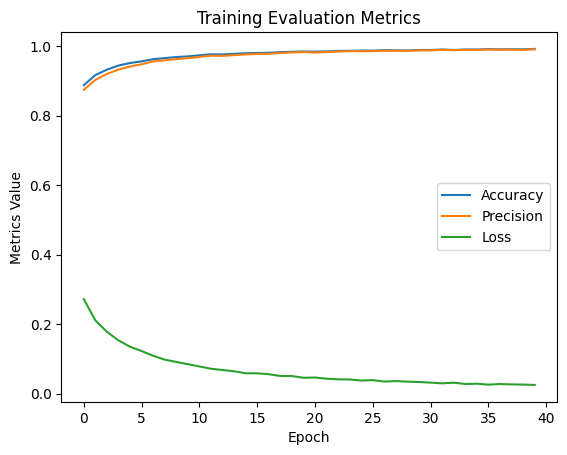

In [16]:
import matplotlib.pyplot as plt

# Sample data for illustration purposes
history = {'accuracy': [0.6, 0.7, 0.8, 0.9],
           'loss': [0.5, 0.4, 0.3, 0.2],
           'precision': [0.7, 0.8, 0.85, 0.9]}

# Plot accuracy
plt.plot(model_history.history['accuracy'], label='Accuracy')

# Plot precision
plt.plot(model_history.history['precision'], label='Precision' )

# Plot loss
plt.plot(model_history.history['loss'], label='Loss')

# Set plot labels and title
plt.title('Training Evaluation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics Value')

# Add legend
plt.legend()

picturePath = "{}Model_Training_Evaluation_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, method, dataSetName, numberOfEpochs)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')

plt.show()
plt.close()


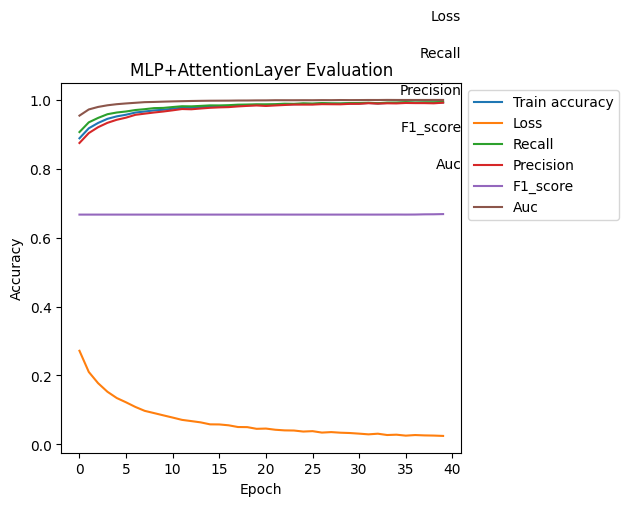

In [17]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(model_history.history['accuracy'], label='Train accuracy')
#plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.title('MLP+AttentionLayer Evaluation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Add additional metrics and adjust label positions
metrics = ['loss', 'recall', 'precision', 'f1_score', 'auc']
for i, metric in enumerate(metrics):
    plt.plot(model_history.history[metric], label=metric.capitalize())
    y_offset = (i - 2) * 0.1  # Adjust based on desired spacing
    plt.text(1, 1 - y_offset, metric.capitalize(), verticalalignment='top', ha='right', transform=plt.gca().transAxes)

# Adjust layout and legend
plt.subplots_adjust(right=0.75)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save and clear plot
picturePath = "{}Result_ModelEvaluation_{}_{}.png".format(dataSetResultDirectory, "MLP+AttentionLayer Model", dataSetName)
plt.savefig(picturePath, dpi=300, bbox_inches='tight')
plt.show()
plt.close()


Total Features: 56914 -> Selected for SHAP:: 22765
Total Test: 14228 -> Selected for SHAP:: 5691


PermutationExplainer explainer: 5692it [25:10,  3.75it/s]                          


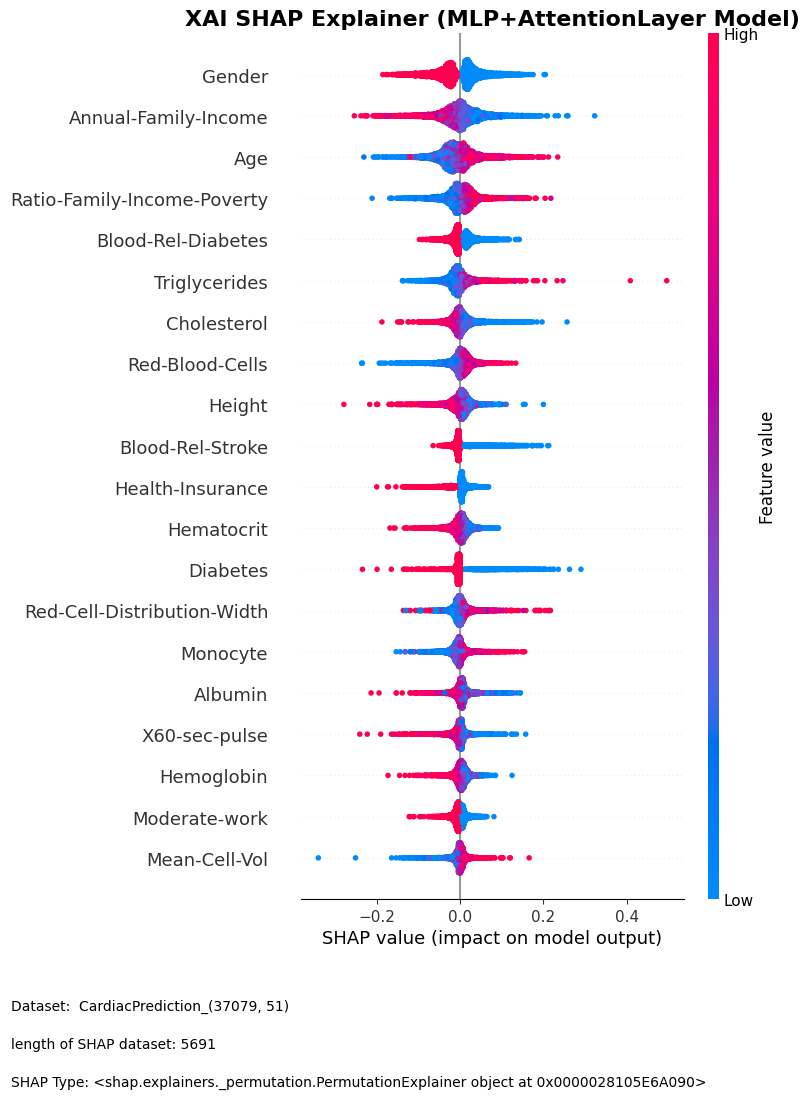

In [18]:
percentage = 0.40
numberOfFeatures = int(len(features) *percentage)
print("Total Features: {} -> Selected for SHAP:: {}".format(len(features), numberOfFeatures))
featuresForShap = X_train.columns #features[0:numberOfFeatures]
#print(" Features Name: {}".format(  featuresForShap))

numberOftest = int(len(X_test_scaler) * percentage)
print("Total Test: {} -> Selected for SHAP:: {}".format(len(X_test_scaler), numberOftest))
testForShap = X_test_scaler[0:len(featuresForShap)]
testForShap = X_test_scaler[0:numberOftest]
#print(" testForShap Name: {}".format(  testForShap))


shap_explainer = shap.Explainer(model, feature_names=featuresForShap, masker=shap.maskers.Independent(data=testForShap)) 
shap_values = shap_explainer.shap_values(testForShap)  

def makeSHAPreport(method, model):
    shap.summary_plot(shap_values, testForShap, featuresForShap, show=False)
    ax = mplot.gca() 
    ax.set_title("XAI SHAP Explainer ({} Model)".format(method) ,fontsize=16, fontweight='bold')     

    dataSetString = "Dataset:  {}".format(dataSetName)
    testingDatasetString ="length of SHAP dataset: {}".format(len(testForShap))
    shapTypeString ="SHAP Type: {}".format(repr(shap_explainer)) 
    ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
    ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   
    ax.figure.text(0.020, -0.13,  shapTypeString, horizontalalignment='left', wrap=False )   

    picturePath = "{}XAI_SHAP_Explainer_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    #mplot.savefig(picturePath,  dpi=300) 
    mplot.show()
    #os.startfile(picturePath)
    mplot.close()


makeSHAPreport("MLP+AttentionLayer", model)

[ 1  3  2  4 48 40 30 16  9 49 46 24 47 25 13 26  5 17 45 18 37 21 23 22
 38 15  7  0 11 34 42 36 39  6 27 20 33 29 10 12 41 44 35 14  8 31 19 43
 32 28]
Index(['Gender', 'Annual-Family-Income', 'Age', 'Ratio-Family-Income-Poverty',
       'Blood-Rel-Diabetes', 'Triglycerides', 'Cholesterol', 'Red-Blood-Cells',
       'Height', 'Blood-Rel-Stroke', 'Health-Insurance', 'Hematocrit',
       'Diabetes', 'Red-Cell-Distribution-Width', 'Monocyte', 'Albumin',
       'X60-sec-pulse', 'Hemoglobin', 'Moderate-work', 'Mean-Cell-Vol',
       'Bilirubin', 'Platelet-count', 'Segmented-Neutrophils',
       'Mean-Platelet-Vol', 'Protein', 'Basophils', 'Diastolic', 'SEQN',
       'White-Blood-Cells', 'Iron', 'HDL', 'Phosphorus', 'Uric.Acid',
       'Systolic', 'ALP', 'Mean-cell-Hemoglobin', 'GGT', 'ALT',
       'Body-Mass-Index', 'Lymphocyte', 'Total-Cholesterol', 'Vigorous-work',
       'LDH', 'Eosinophils', 'Weight', 'Creatinine', 'Mean-Cell-Hgb-Conc.',
       'Glycohemoglobin', 'Glucose', 'AST'],
  

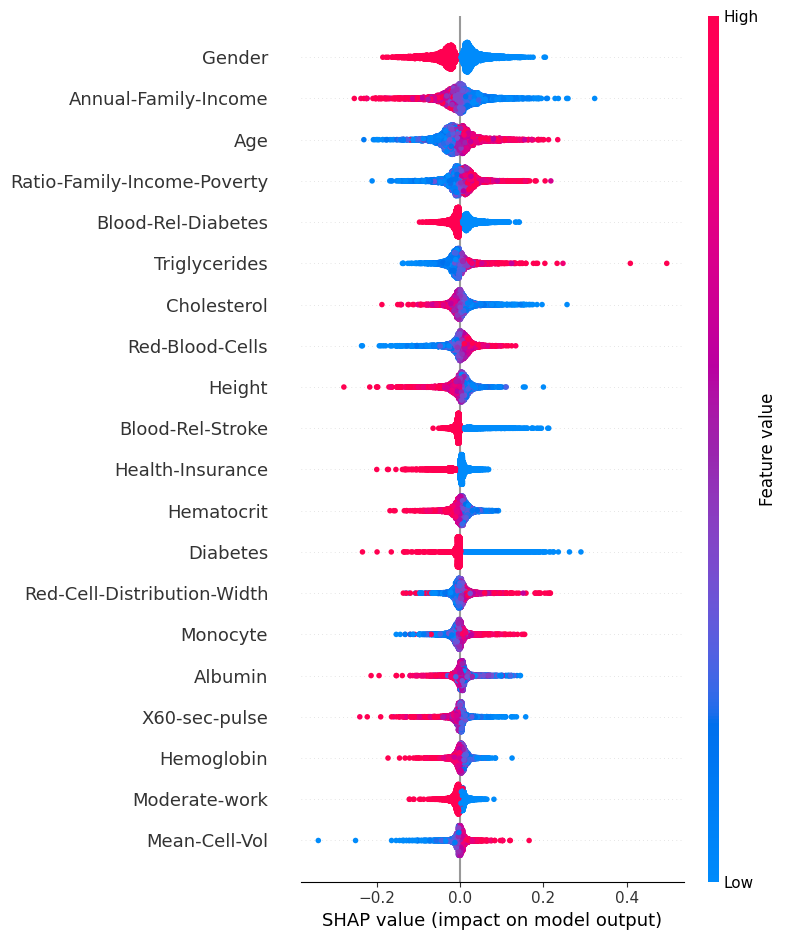

In [34]:
featureImportance = np.abs(shap_values).mean(axis=0)
top_features_indices = np.argsort(featureImportance)[::-1]
topFeatures = testForShap[:, top_features_indices]
topShapValues = shap_values[:, top_features_indices]

print(top_features_indices)
featureNames = X.columns[top_features_indices]
print(featureNames)
print(len(featureNames))



shap.summary_plot(topShapValues, topFeatures, feature_names=featureNames)



In [19]:
feature_names = X.columns.tolist()


# Calculate average SHAP values across all instances
avg_shap_values = np.mean(shap_values, axis=0)

# Print average SHAP values according to feature names
print("Average SHAP values:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {avg_shap_values[i]*100.0}")

Average SHAP values:
SEQN: 0.01118952637743109
Gender: -0.3739511009125127
Age: -0.5205982114433624
Annual-Family-Income: -0.05821074068430655
Ratio-Family-Income-Poverty: 0.21724423781702215
X60-sec-pulse: -0.2907111670792468
Systolic: 0.13994631733492338
Diastolic: -0.08036656284338607
Weight: 0.020526850032246535
Height: -0.08333863303556514
Body-Mass-Index: -0.11147367177531381
White-Blood-Cells: 0.07229287681454583
Lymphocyte: -0.12345862657956047
Monocyte: -0.36916545675579765
Eosinophils: 0.006980594149267635
Basophils: -0.10467704352812514
Red-Blood-Cells: 0.11909350675459672
Hemoglobin: 0.22345475284118607
Mean-Cell-Vol: -0.14905264089903303
Mean-Cell-Hgb-Conc.: -0.005017681265618603
Mean-cell-Hemoglobin: 0.02381777011496567
Platelet-count: -0.06046926511911368
Mean-Platelet-Vol: 0.05343621639312388
Segmented-Neutrophils: -0.20559496594855084
Hematocrit: 0.08801116194898263
Red-Cell-Distribution-Width: 0.16630886932210803
Albumin: 0.34000398377075547
ALP: 0.08970667125519566
A

In [35]:
avg_shap_values = np.mean(shap_values, axis=0)
# Get indices that would sort the average SHAP values
sorted_indices = np.argsort(avg_shap_values)[::-1]
# Arrange feature names and average SHAP values in ascending order
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_avg_shap_values = avg_shap_values[sorted_indices]
# Print sorted feature names and average SHAP values
print("Sorted Average SHAP values:")
for i in range(len(sorted_feature_names)):
    print(f"{sorted_feature_names[i]}: {sorted_avg_shap_values[i]*100.0}")

Sorted Average SHAP values:
Diabetes: 0.47153587441162453
Blood-Rel-Diabetes: 0.41748000434214105
Albumin: 0.34000398377075547
Blood-Rel-Stroke: 0.2628107722024543
Cholesterol: 0.2277853772936544
Hemoglobin: 0.22345475284118607
Ratio-Family-Income-Poverty: 0.21724423781702215
Bilirubin: 0.16687327065540328
Red-Cell-Distribution-Width: 0.16630886932210803
Systolic: 0.13994631733492338
Glucose: 0.12186496323108742
Red-Blood-Cells: 0.11909350675459672
ALP: 0.08970667125519566
Hematocrit: 0.08801116194898263
White-Blood-Cells: 0.07229287681454583
Creatinine: 0.06285447639196429
Mean-Platelet-Vol: 0.05343621639312388
AST: 0.02558644525839611
Mean-cell-Hemoglobin: 0.02381777011496567
Weight: 0.020526850032246535
SEQN: 0.01118952637743109
Eosinophils: 0.006980594149267635
Total-Cholesterol: 0.0031643611853698736
Iron: 0.0026500483989323424
Glycohemoglobin: -0.004494217917299559
Mean-Cell-Hgb-Conc.: -0.005017681265618603
Health-Insurance: -0.017981989399439145
Vigorous-work: -0.041950956469426

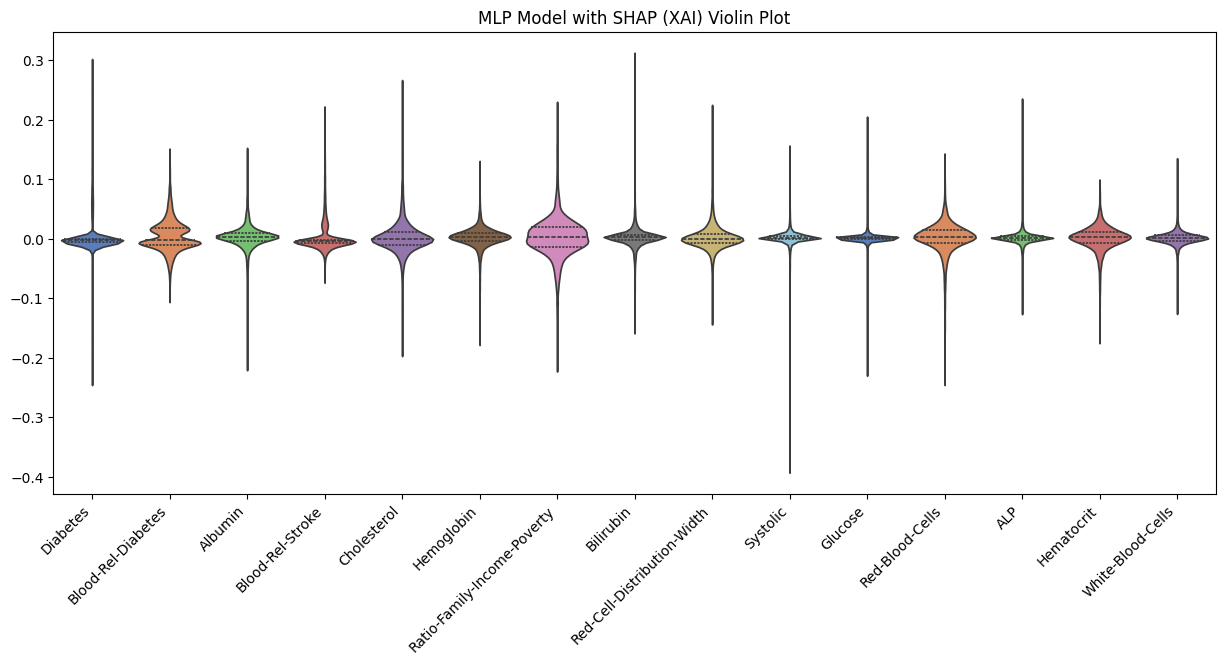

In [37]:
# Arrange feature names and average SHAP values in ascending order
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_avg_shap_values = avg_shap_values[sorted_indices]

# Select the top 10 features
top_10_feature_indices = sorted_indices[:15]
top_10_feature_names = [feature_names[i] for i in top_10_feature_indices]
top_10_shap_values = shap_values[:, top_10_feature_indices]

# Create a DataFrame for visualization
df_top_10 = pd.DataFrame(data=top_10_shap_values, columns=top_10_feature_names)

# Plotting with Seaborn's violinplot
plt.figure(figsize=(15, 6))
sns.violinplot(data=df_top_10, inner="quartile", palette="muted") 
plt.title('MLP Model with SHAP (XAI) Violin Plot')
plt.xticks(rotation=45, ha='right')

picturePath = "{}XAI_SHAP_Explainer_SNS_Violinplot_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

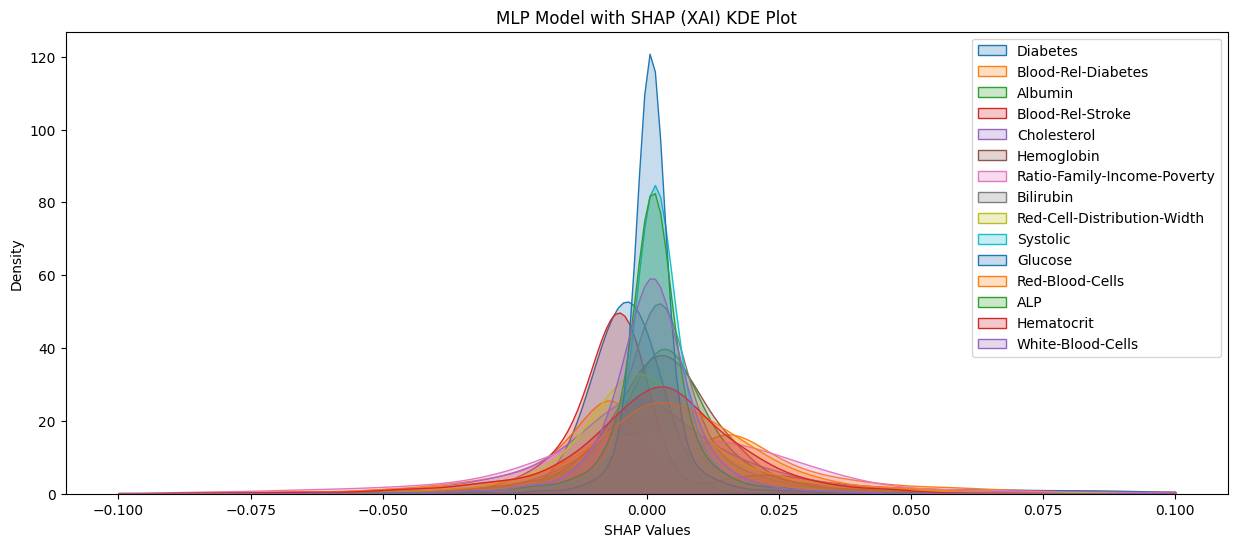

In [38]:
# Plotting with Seaborn's kdeplot
# Set the x-axis range
x_axis_range = (-0.10, 0.10)  # Adjust the range as needed
plt.figure(figsize=(15, 6))
for feature in top_10_feature_names:
    sns.kdeplot(data=df_top_10[feature], label=feature, common_norm=False, common_grid=True, fill=True, clip=x_axis_range)
 

plt.title('MLP Model with SHAP (XAI) KDE Plot')
plt.xlabel('SHAP Values')
plt.ylabel('Density')
plt.legend()
picturePath = "{}XAI_SHAP_Explainer_SNS_KDEplot_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

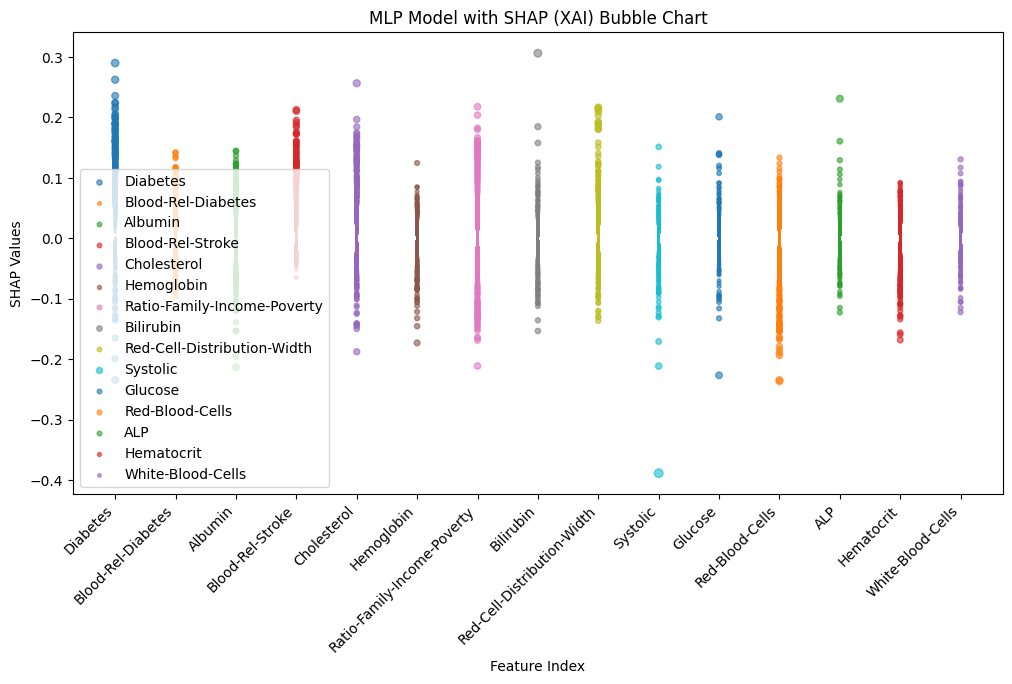

In [39]:
# Plotting a Bubble Chart
plt.figure(figsize=(12, 6))

for i, feature in enumerate(top_10_feature_names):
    size = np.abs(df_top_10[feature]) * 100  # Adjust the scale as needed
    plt.scatter(x=[i] * len(df_top_10), y=df_top_10[feature], s=size, label=feature, alpha=0.6)
 
plt.title('MLP Model with SHAP (XAI) Bubble Chart')
plt.xlabel('Feature Index')
plt.ylabel('SHAP Values')
plt.xticks(range(len(top_10_feature_names)), top_10_feature_names, rotation=45, ha='right')
plt.legend()

picturePath = "{}XAI_SHAP_Explainer_SNS_BubbleChart_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

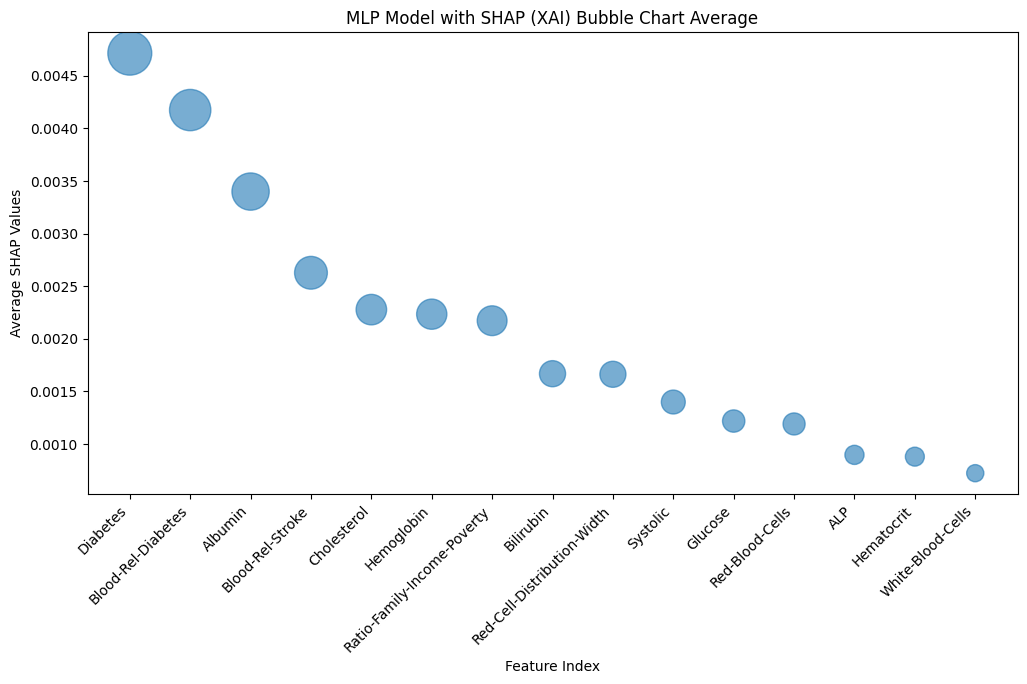

In [41]:
 # Select the top 10 features
top_10_feature_indices = sorted_indices[:15]
top_10_feature_names = [feature_names[i] for i in top_10_feature_indices]
top_10_avg_shap_values = avg_shap_values[top_10_feature_indices]

# Calculate the scale for bubble size based on the average values compared to others
size_scale = np.abs(top_10_avg_shap_values) / np.max(np.abs(top_10_avg_shap_values))

# Create a DataFrame for visualization
df_top_10_avg_shap = pd.DataFrame({'Feature': top_10_feature_names, 'Average SHAP Value': top_10_avg_shap_values})

# Plotting a Bubble Chart for top 10 average SHAP values
plt.figure(figsize=(12, 6))

size = size_scale * 1000  # Adjust the scale as needed
plt.scatter(x=range(len(df_top_10_avg_shap)), y=df_top_10_avg_shap['Average SHAP Value'], s=size, alpha=0.6)

plt.title('MLP Model with SHAP (XAI) Bubble Chart Average')
plt.xlabel('Feature Index')
plt.ylabel('Average SHAP Values')
plt.xticks(range(len(df_top_10_avg_shap)), df_top_10_avg_shap['Feature'], rotation=45, ha='right')

picturePath = "{}XAI_SHAP_Explainer_SNS_BubbleChartAverage_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [42]:
import plotly.graph_objects as go
# Plotting a Sankey Diagram for the selected instance

# Assuming your features are in a pandas DataFrame, you can access feature names
feature_names = X.columns.tolist()

# Aggregate SHAP values across instances
aggregated_shap_values = np.sum(shap_values, axis=0)
 
 
# Define custom colors for nodes and links
node_colors = ['rgba(102, 197, 204, 0.8)' for _ in feature_names] + ['rgba(255, 102, 102, 0.8)']  # Light blue for features, light red for prediction
link_colors = ['rgba(102, 197, 204, 0.5)' for _ in feature_names] * len(shap_values)  # Light blue for links

# Plotting a Sankey Diagram of Energy Flow for aggregated SHAP values
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=feature_names + ['Prediction'],
        color=node_colors
    ),
    link=dict(
        source=[feature_names.index(feature) for feature in feature_names] * len(shap_values),
        target=[len(feature_names)] * len(feature_names) * len(shap_values),
        value=np.tile(aggregated_shap_values, len(shap_values)).tolist() + [np.sum(aggregated_shap_values)] * len(shap_values),
        color=link_colors

    )
)])


fig.update_layout(title_text="Sankey Diagram of Aggregated SHAP Values")

picturePath = "{}XAI_SHAP_Explainer_Sankey_Diagram_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
#fig.write_image(picturePath)
fig.show() 

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

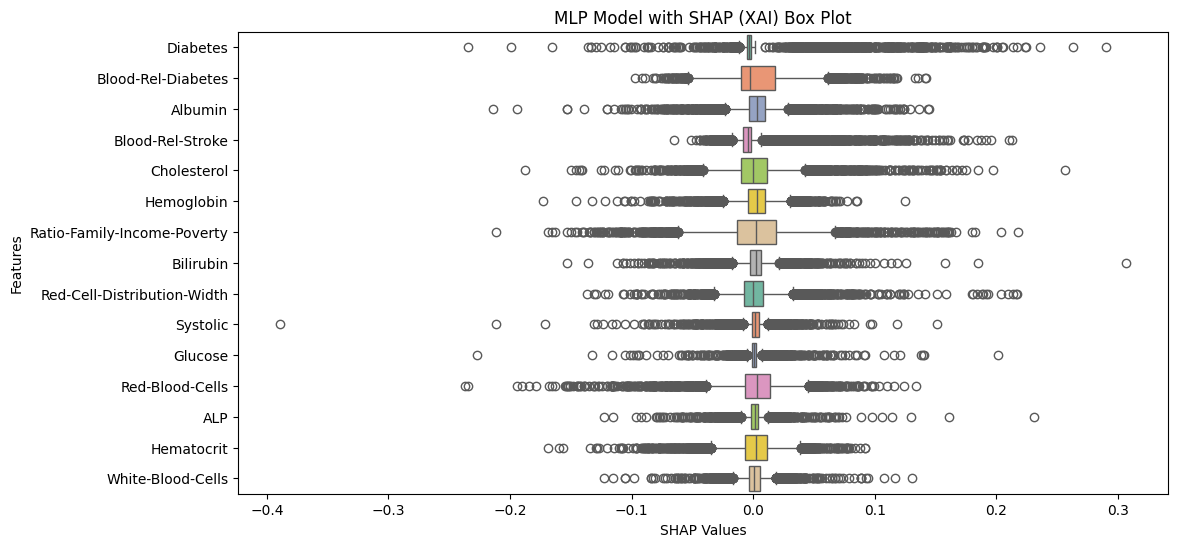

In [43]:
# Plotting a boxplot for the top 10 features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_10, orient='h', palette='Set2')


plt.title('MLP Model with SHAP (XAI) Box Plot')
plt.xlabel('SHAP Values')
plt.ylabel('Features')

picturePath = "{}XAI_SHAP_Explainer_SNS_BoxPlot_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

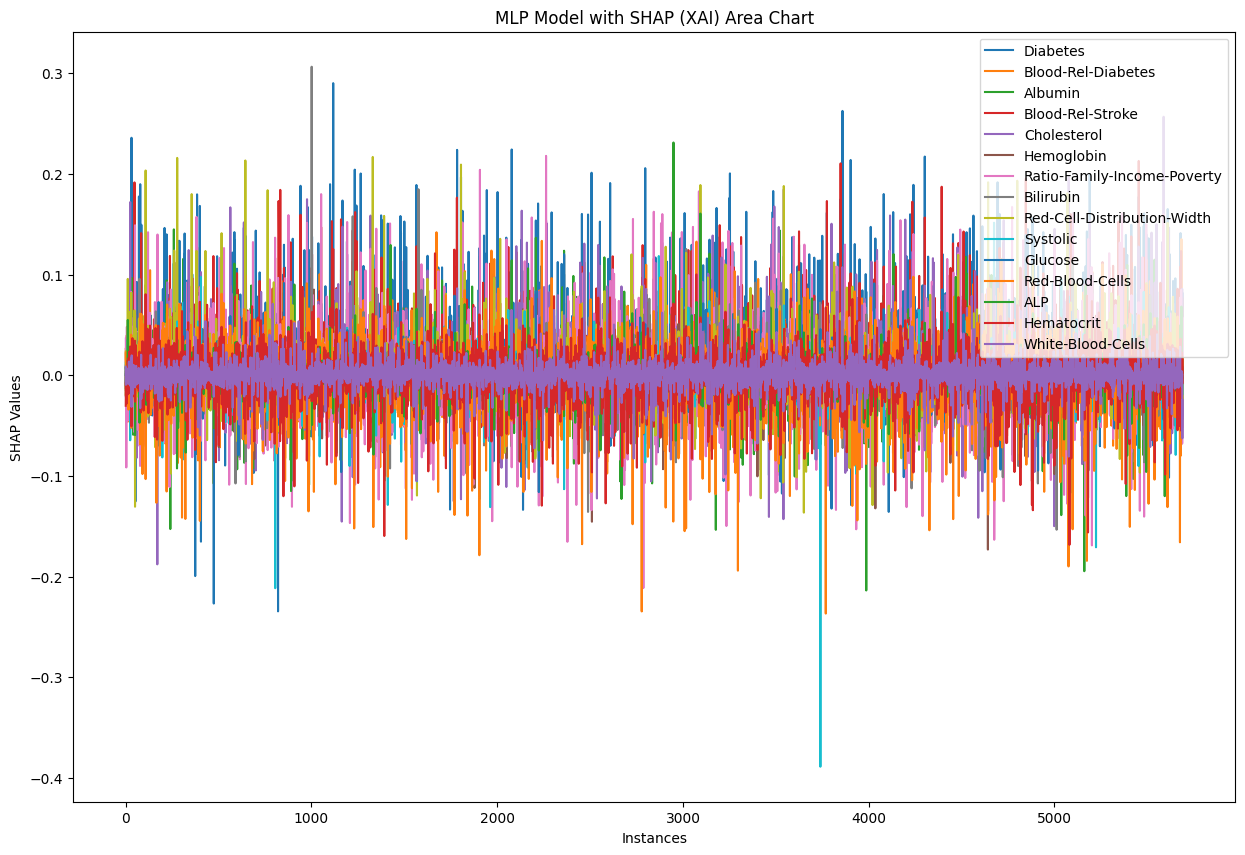

In [44]:
# Plotting an area chart for all SHAP values of the top 10 features
plt.figure(figsize=(15, 10))
for feature in top_10_feature_names:
    sns.lineplot(x=range(df_top_10.shape[0]), y=df_top_10[feature], label=feature)
 
plt.title('MLP Model with SHAP (XAI) Area Chart')

plt.xlabel('Instances')
plt.ylabel('SHAP Values')
plt.legend(loc='upper right')

picturePath = "{}XAI_SHAP_Explainer_SNS_AreaChart_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

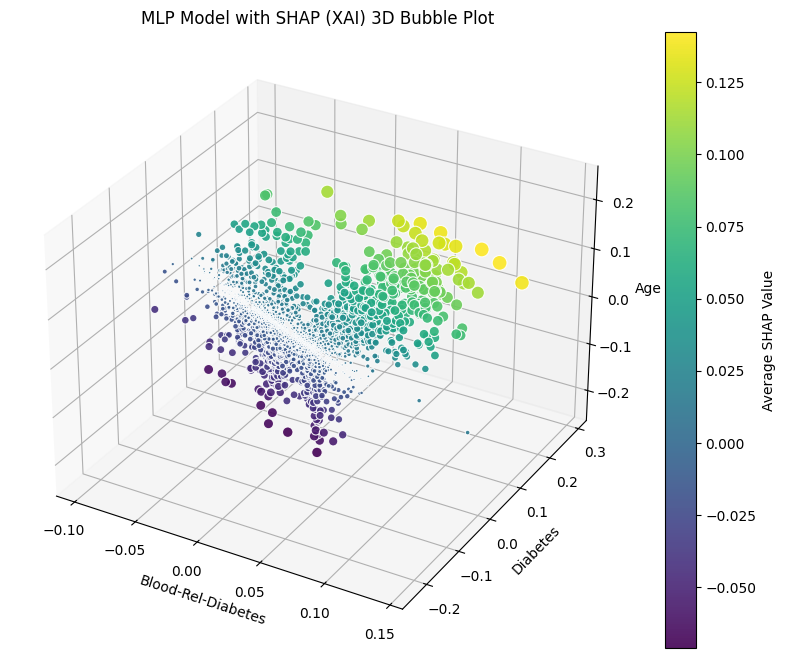

In [45]:
from mpl_toolkits.mplot3d import Axes3D


# Assuming your features are in a pandas DataFrame, you can access feature names
feature_names = X.columns.tolist()
# Get the top 3 features based on their absolute average SHAP values
top_3_feature_indices = np.argsort(np.abs(shap_values.mean(0)))[-3:]
top_3_feature_names = [feature_names[i] for i in top_3_feature_indices]
# Extract SHAP values for the top 3 features
shap_values_top_3 = shap_values[:, top_3_feature_indices]
# Create a DataFrame for visualization
df_top_3 = pd.DataFrame(data=shap_values_top_3, columns=top_3_feature_names)

# Create a 3D bubble plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
 

# Scatter plot with adjusted size and color
scatter = ax.scatter(df_top_3[top_3_feature_names[0]], df_top_3[top_3_feature_names[1]], df_top_3[top_3_feature_names[2]],
                     s=800 * np.abs(df_top_3.mean(axis=1)),  # Adjust the size
                     c=df_top_3.mean(axis=1), cmap='viridis', alpha=0.9, edgecolors='w', linewidth=0.8)  # Adjust the color

# Add labels and title
ax.set_xlabel(top_3_feature_names[0])
ax.set_ylabel(top_3_feature_names[1])
ax.set_zlabel(top_3_feature_names[2])
ax.set_title('3D Bubble Plot of Top 3 Features')
plt.title('MLP Model with SHAP (XAI) 3D Bubble Plot')


# Add colorbar
colorbar = plt.colorbar(scatter, ax=ax, label='Average SHAP Value')

picturePath = "{}XAI_SHAP_Explainer_SNS_BubblePlot_3D_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [46]:
# Plotting with Seaborn's swarmplot (Beeswarm plot)
plt.figure(figsize=(12, 6))
sns.swarmplot(data=df_top_10, palette="muted", size=3) 
plt.title('MLP Model with SHAP (XAI) Beeswarm Plot')
plt.ylabel('SHAP Values')
plt.xticks(rotation=45, ha='right')

picturePath = "{}XAI_SHAP_Explainer_SNS_Beeswarmplot_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3398: UserWarning:

93.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3398: UserWarning:

94.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3398: UserWarning:

94.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3398: UserWarning:

94.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3398: UserWarning:

9

In [ ]:
shap.summary_plot(shap_values, testForShap, featuresForShap, plot_type='bar', show=False)
ax = mplot.gca() 
ax.set_title("XAI SHAP Explainer ({} Model)".format(method) ,fontsize=16, fontweight='bold')    

'''
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString ="length of Testing Set: {}".format(len(testForShap))
shapTypeString ="SHAP Type: {}".format(repr(shap_explainer)) 
ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   
ax.figure.text(0.020, -0.13,  shapTypeString, horizontalalignment='left', wrap=False )   
'''

picturePath = "{}XAI_SHAP_Explainer_BAR_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
mplot.show()
mplot.close()

# Print or use the te

In [ ]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Concatenate


# Assuming 'features' is your input data
X_train_forLime, X_test_forLime, y_train_forLime, y_test_forLime = train_test_split(features, target, test_size=0.2, random_state=42)
 
# Wrap the TensorFlow model for LIME
class LimeModelWrapper:
    def __init__(self, model, feature_names):
        self.model = model
        self.feature_names = feature_names

    '''
    def predict_proba(self, instances):
        # Ensure the model outputs probabilities
        raw_predictions = self.model.predict(instances)
        probabilities = tf.nn.softmax(raw_predictions, axis=-1).numpy()
        return probabilities.tolist() 
    '''
    def predict_proba(self, instances):
        # Ensure the model outputs probabilities
        instances = np.array(instances)  # Convert to NumPy array
        #if len(instances.shape) == 1: instances = instances.reshape(1, -1)  # Reshape to 2D if it's 1D
        raw_predictions = self.model.predict(instances)
        probabilities = tf.nn.softmax(raw_predictions, axis=-1).numpy()
        return probabilities   # Convert the array to a list



lime_model = LimeModelWrapper(model, featuresForShap)


#print("featuresForShap: {}".format(featuresForShap))

# Instantiate LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer( np.array(X_train_forLime), mode='classification', feature_names=featuresForShap, verbose=True, class_names=["Healthy", "Heart Patient"] ) 

# Generate explanations for each testing instance
instance = X_test_forLime
num_instances = 50 # int(len(X_test_forLime) / 4)
print("num_instances: {}".format(num_instances))

explanations = [] 


for i in range(num_instances):
    instan = instance[i]
    #print(instan.dtype)
    #print(instan.shape)
    #print("Instance {}: {}".format(i, instan))  # Add this line to print the instance
    prediction = lime_model.predict_proba([instan])
    print("Model Prediction for Instance {}: {}".format(i, prediction))  # Add this line to print the model prediction
    explanation = explainer.explain_instance(
        instan,
        lime_model.predict_proba,
        num_features=len(featuresForShap),
        top_labels=1,
        labels=[1],
        num_samples=1000  # Adjust the number of samples here
    )
    explanations.append(explanation)
    print("Explanation Map for Instance {}: {}".format(i, explanation.as_map())) 




In [ ]:
feature_importances = [exp.as_map()[1] for exp in explanations if 1 in exp.as_map()]
print("Feature Importances: {}".format(feature_importances))

# Check if the feature_importances list is not empty
if feature_importances: 
    feature_importances = feature_importances[0]
else: 
    feature_importances = [(i, 0.0) for i in range(len(featuresForShap))]

averageF = [singleFeature[1] for singleFeature in feature_importances]


print("\n\nfeature_list:{}".format(featuresForShap))
print("averageF:{} \n\n".format(averageF))


# Plot the feature importances
fig, ax = plt.subplots()
ax.barh(featuresForShap, averageF)
ax.set_ylabel('Feature List')
ax.set_xlabel('Average Importance')
ax.set_title("XAI LIME ({} Model)".format(method), fontsize=16, fontweight='bold')

# Additional information
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString = "Length of Testing Set: {}".format(len(X_test_forLime))
explainerModelString = "LIME Explainer Model: {}".format(explainer.mode)
ax.figure.text(0.020, -0.05, dataSetString, horizontalalignment='left', wrap=False)
ax.figure.text(0.020, -0.09, testingDatasetString, horizontalalignment='left', wrap=False)
ax.figure.text(0.020, -0.13, explainerModelString, horizontalalignment='left', wrap=False)

# Save and show the plot
picturePath = "{}XAI_LIME_2_{}_{}.png".format(dataSetResultDirectory, method, dataSetName)
plt.savefig(picturePath, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
import datetime
currentDateTime = datetime.datetime.now() 
currentDateTime = currentDateTime.strftime("%Y%m%d %H%M") 
modelPath = "{}model02_trained_{}_{}_{}percent.model".format(dataSetResultDirectory, dataSetName, currentDateTime, accuracy)
print(modelPath)
model2.save(modelPath)